# Euclidean space

* Load original embeddings
* Euclidean MDS

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import re, seaborn as sns
from sklearn.manifold import MDS
from scipy import stats
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

data_dir = '../data'
output_dir = '../outputs'

In [2]:
np.random.seed(0) # same results every time

In [3]:
# load distance matrix
input_distance_matrix = pd.read_csv(os.path.join(data_dir, 'coef_embed.csv'), header=None).to_numpy()
input_distance_matrix.shape

(49, 49)

In [4]:
### Multi-dimensional scaling
embedding = MDS(n_components=3)
transformed_dist = embedding.fit_transform(input_distance_matrix)
# eu_dist = np.corrcoef(transformed_dist, rowvar=True)
# eu_dist = 1 - abs(eu_dist)
eu_dist = distance_matrix(transformed_dist, transformed_dist)

stats.spearmanr(eu_dist.flatten(),input_distance_matrix.flatten()) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


SpearmanrResult(correlation=0.3410559291285408, pvalue=1.815838108395617e-66)

In [5]:
# load original 1854*49 embeddings (1854 concepts represented by 49 features)
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [6]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

,cr,bigcat
smallcat,,
1,0.779739,1
2,0.798485,13
3,0.752845,18
4,0.761851,99
5,0.794466,9
...,...,...
1850,0.722655,99
1851,0.843158,10
1852,0.800163,1


In [7]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


,cr,bigcat,cat_name
0,0.779739,1,animal
1,0.798485,13,home decor
2,0.752845,18,musical instrument
3,0.761851,99,NaN
4,0.794466,9,electronic device
...,...,...,...
1849,0.722655,99,NaN
1850,0.843158,10,food
1851,0.800163,1,animal
1852,0.797468,99,NaN


In [8]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

,cat,concept,typicality
0,1,0,4.874352
1,1,12,6.374555
2,1,15,5.342846
3,1,24,4.655669
4,1,25,5.288886
...,...,...,...
1614,27,1602,7.456293
1615,27,1620,5.922099
1616,27,1684,5.219242
1617,27,1712,3.238293


# Analysis

1. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
2. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        


In [9]:
### normalize embeddings and transform concept embeddings to loadings in feature space
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
concept_in_feat_coord = normalized_embeddings@transformed_dist
np.array(concept_in_feat_coord).shape

(1854, 3)

In [10]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(concept_in_feat_coord).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

,index,0,1,2,cr,bigcat,cat_name
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument
4,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device
5,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture
...,...,...,...,...,...,...,...
1847,1847,0.215718,0.272371,0.461966,0.803129,24,toy
1848,1848,-0.476999,0.372665,-0.809425,0.765881,10,food
1850,1850,-0.575528,0.803189,-0.450914,0.843158,10,food
1851,1851,0.029682,0.494576,-0.731155,0.800163,1,animal


<IPython.core.display.Javascript object>


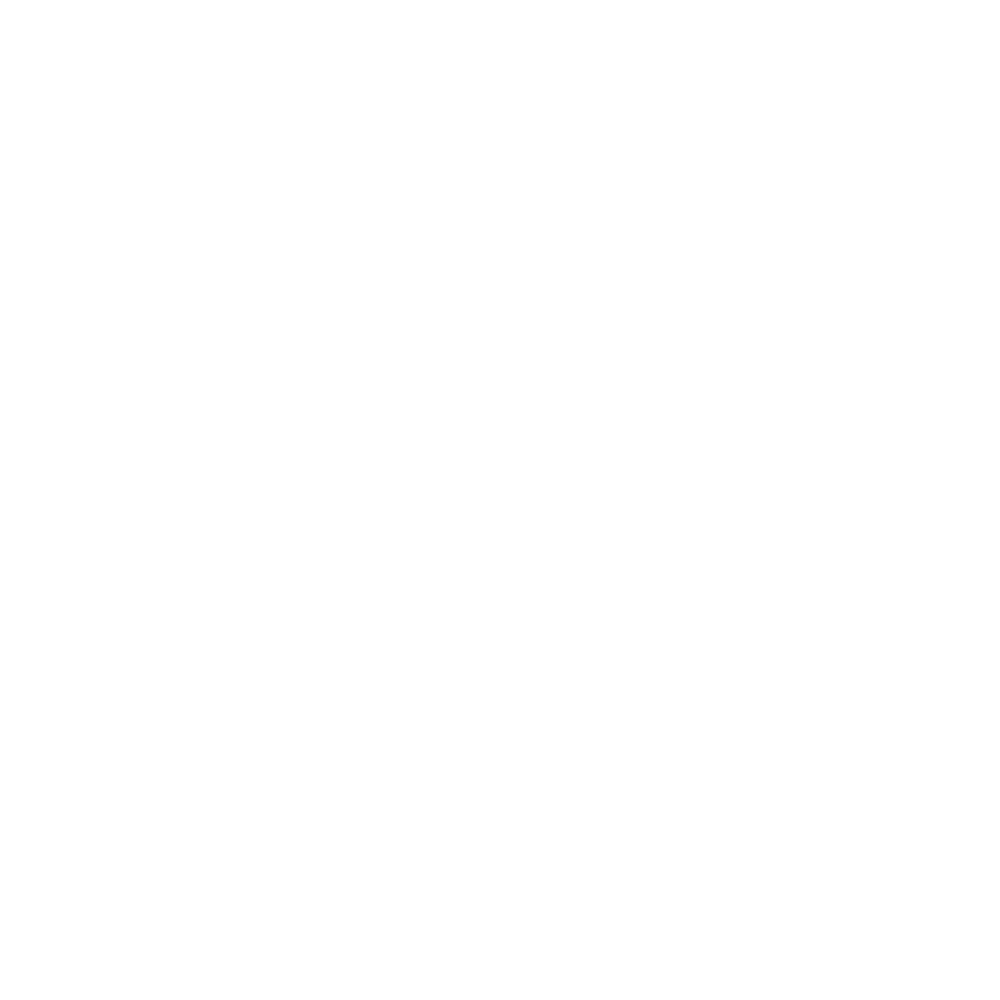

In [11]:
# Visualize concepts in 3D Euclidean space
from matplotlib import animation
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# ax.axes.set_xlim3d(left=-30, right=20) 
# ax.axes.set_ylim3d(bottom=-30, top=20) 
# ax.axes.set_zlim3d(bottom=-30, top=20) 

concept_cat = ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], alpha=0.6) 
ax.scatter(transformed_dist.T[0], transformed_dist.T[1], transformed_dist.T[2], color='red')

# def animate(frame):
#     ax.view_init(60, frame)
#     plt.pause(.0001)
#     return fig

# anim = animation.FuncAnimation(fig, animate, frames=50, interval=.1, repeat=True)
# anim.save('../outputs/feat_concept_rotate.gif', writer='pillow')

plt.show()

<IPython.core.display.Javascript object>


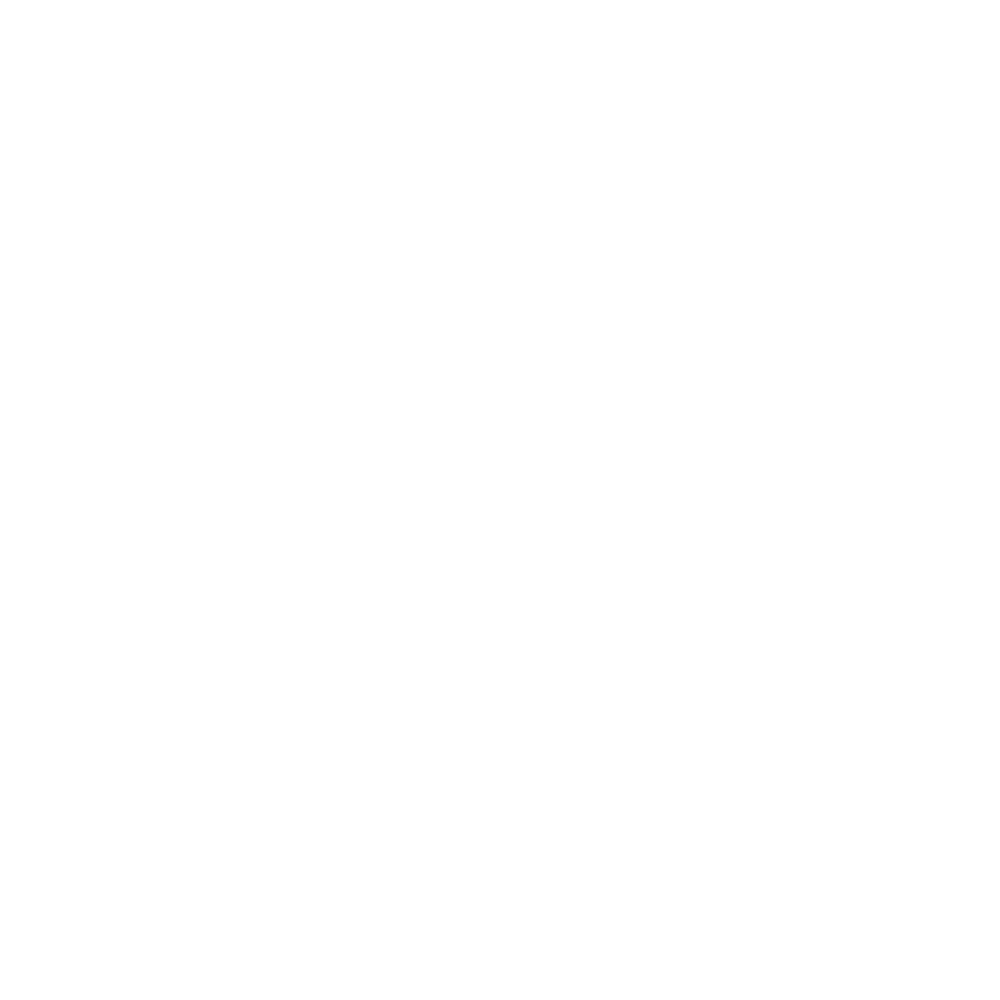

In [12]:
### Color-coded categories
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Cartesian

In [13]:
coordinates = mean_concept_in_feat_cat.loc[:, 0:2]
coordinates

,0,1,2
0,0.051500,0.483172,-0.980202
1,-0.607218,0.881249,-0.366100
2,-0.697082,1.164975,-0.555658
3,-0.912856,0.811433,-0.596981
4,-0.687007,0.409919,-0.505287
...,...,...,...
1849,-0.906150,0.392203,-0.963531
1850,-0.575528,0.803189,-0.450914
1851,0.029682,0.494576,-0.731155
1852,-0.547654,-0.133760,-0.733928


In [14]:
### linreg: cartesian coordinates predict z-score memorability
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(coordinates, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     95.18
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.74e-57
Time:                        15:59:00   Log-Likelihood:                -2497.7
No. Observations:                1854   AIC:                             5003.
Df Residuals:                    1850   BIC:                             5025.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1170      0.044     -2.639      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Polar coordinates

In [15]:
# ### Polar coordinates of concepts in hyperbolic feature space
# r, theta, rho = cart_to_polar(coordinates.values).T
# plt.hist2d(theta, rho,
#            bins = 20)

### Radius
small R^2, with concepts closer to the core/origin being more memorable

<IPython.core.display.Javascript object>


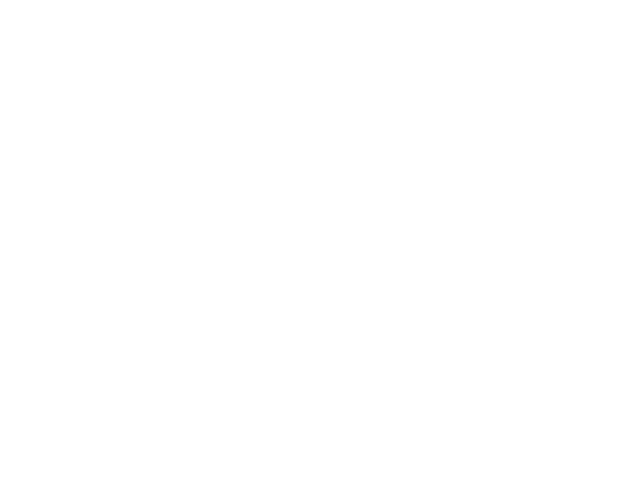

(array([ 11.,  58., 128., 208., 341., 440., 317., 239.,  93.,  19.]),
 array([0.12994871, 0.31106223, 0.49217575, 0.67328928, 0.8544028 ,
        1.03551632, 1.21662985, 1.39774337, 1.57885689, 1.75997041,
        1.94108394]),
 <BarContainer object of 10 artists>)

In [16]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((coordinates**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [17]:
### Radius predict memorability
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     36.15
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.19e-09
Time:                        15:59:00   Log-Likelihood:                -2612.8
No. Observations:                1854   AIC:                             5230.
Df Residuals:                    1852   BIC:                             5241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.4332      0.072     -6.013      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### KMeans: clustering concepts as we did in hyperbolic space

In [18]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(coordinates)
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)
print(inertia)

[1471.7849947730897, 1017.3720714578043, 775.1140013490352, 627.9404764945127, 540.4449599737998, 483.2870757497567, 442.9743056264868, 408.05514523191994, 380.7079603045585, 356.8644469008005, 333.3876509956449, 315.22047333480793, 297.79597687394346, 283.6551602989506]


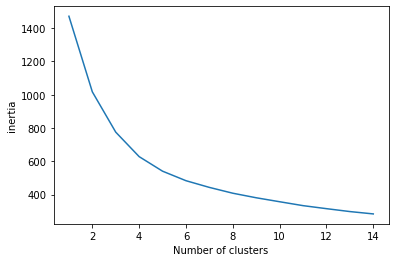

In [19]:
%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()
    

In [20]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(coordinates)
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-0.77759357,  0.62793986, -0.45351111],
       [-0.26654746, -0.57590185, -0.17010613],
       [-0.26210081,  0.35615432, -1.05336103],
       [ 0.21058891,  0.70921961, -0.30746036]])

<IPython.core.display.Javascript object>


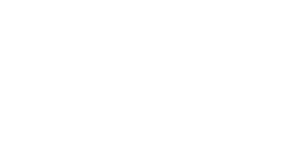

In [21]:
%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.7)
ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.7)
ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.7)
plt.legend()


In [22]:
### cluster 0: cartesian coordinates predict memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:2], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.958
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.32e-05
Time:                        15:59:03   Log-Likelihood:                -805.53
No. Observations:                 576   AIC:                             1619.
Df Residuals:                     572   BIC:                             1636.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3034      0.165      1.844      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
### cluster 0: radius predict memorability
radius_cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(radius_cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_0.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     26.72
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.25e-07
Time:                        15:59:03   Log-Likelihood:                -804.21
No. Observations:                 576   AIC:                             1612.
Df Residuals:                     574   BIC:                             1621.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7878      0.152     -5.169      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
### cluster 1: cartesian coordinates predict memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:2], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     31.07
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           7.65e-18
Time:                        15:59:03   Log-Likelihood:                -463.32
No. Observations:                 356   AIC:                             934.6
Df Residuals:                     352   BIC:                             950.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3121      0.107     -2.913      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
### cluster 1: radius predict memorability
radius_cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(radius_cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_1.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     34.54
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           9.63e-09
Time:                        15:59:03   Log-Likelihood:                -488.57
No. Observations:                 356   AIC:                             981.1
Df Residuals:                     354   BIC:                             988.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.9649      0.164      5.877      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [26]:
### cluster 2: cartesian coordinates predict memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:2], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.707
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0446
Time:                        15:59:03   Log-Likelihood:                -774.94
No. Observations:                 549   AIC:                             1558.
Df Residuals:                     545   BIC:                             1575.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0035      0.125     -0.028      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
### cluster 2: radius predict memorability
radius_cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(radius_cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_2.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.327
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0214
Time:                        15:59:03   Log-Likelihood:                -776.34
No. Observations:                 549   AIC:                             1557.
Df Residuals:                     547   BIC:                             1565.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3580      0.155     -2.308      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
### cluster 3: cartesian coordinates predict memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:2], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     9.946
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.55e-06
Time:                        15:59:03   Log-Likelihood:                -514.76
No. Observations:                 373   AIC:                             1038.
Df Residuals:                     369   BIC:                             1053.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1676      0.170     -0.988      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
### cluster 3: radius predict memorability
radius_cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(radius_cluster_3['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((radius_cluster_3.loc[:, 0:2]**2).sum(1)), prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     9.154
Date:                Thu, 24 Aug 2023   Prob (F-statistic):            0.00266
Time:                        15:59:03   Log-Likelihood:                -524.72
No. Observations:                 373   AIC:                             1053.
Df Residuals:                     371   BIC:                             1061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4805      0.159     -3.026      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
# variances in mem explained by cartesian coordinates across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2)+ sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.07204947685607466

In [31]:
# variances in mem explained by radius across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
r_squared

0.042245097096709094

### Within-category attraction (correlation distance)

In [32]:
def calculate_typicality(group):
    """
    Calculate within-category attraction of each concept using average correlation distance within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [33]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

,index,0,1,2,cr,bigcat,cat_name,typicality
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,0.810913
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0.247628
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0.624589
4,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0.522380
5,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0.509185
...,...,...,...,...,...,...,...,...
1847,1847,0.215718,0.272371,0.461966,0.803129,24,toy,0.246697
1848,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,0.786900
1850,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0.770485
1851,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,0.764335


In [34]:
### Cartesian coordinates predict typicality
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped.loc[:, 0:2], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     44.20
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.23e-27
Time:                        15:59:03   Log-Likelihood:                -1815.3
No. Observations:                1324   AIC:                             3639.
Df Residuals:                    1320   BIC:                             3659.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2677      0.057     -4.721      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [35]:
### Radius predict typicality
concept_radius_typ = np.sqrt((grouped.loc[:, 0:2]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     33.92
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           7.21e-09
Time:                        15:59:03   Log-Likelihood:                -1861.9
No. Observations:                1324   AIC:                             3728.
Df Residuals:                    1322   BIC:                             3738.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.5109      0.088      5.824      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
### Cartesian coordinates and typicality predict memorability
zscore_mem = stats.zscore(grouped['cr'])
idx = [i for i in range(0, 3)]
idx.append('typicality')
mean_concept_constant = sm.add_constant(np.array(grouped[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['x', 'y', 'z', 'typicality', 'const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     94.48
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.03e-70
Time:                        15:59:03   Log-Likelihood:                -1711.9
No. Observations:                1324   AIC:                             3434.
Df Residuals:                    1319   BIC:                             3460.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.1411      0.053     -2.667      0.0

In [37]:
### Radius and typicality predict memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius','typicality', 'const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     37.66
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.24e-16
Time:                        15:59:03   Log-Likelihood:                -1842.0
No. Observations:                1324   AIC:                             3690.
Df Residuals:                    1321   BIC:                             3705.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.4845      0.088     -5.534      0.0

### Category cohesiveness

In [38]:
def category_cohesive(df, cat_col):
    """
    Test cohesiveness of all categories: avg distance within category / avg distance with all other categories
    """
    within_distance = []
    between_distance = []
    centroids = df.groupby('bigcat')[[0,1,2]].apply(np.mean).reset_index()

    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        wtn_distance = []
        for idx in range(len(category)):
            concept = category.iloc[idx]
            other_concepts = category[category['index'] != concept['index']]
            wtn_distance.append((np.sqrt(((other_concepts[[0,1,2]] - concept[[0,1,2]])**2).sum(1))).mean(0))
        within_distance.append(np.mean(wtn_distance))
        cat_centroid = np.array(centroids[centroids['bigcat'] == cat][[0,1,2]])
        other_centroids = np.array(centroids[centroids['bigcat'] != cat][[0,1,2]])
        btw_distance = (np.sqrt(((other_centroids - cat_centroid)**2).sum(1))).mean(0)
        between_distance.append(btw_distance)
    
    return np.array(within_distance) / np.array(between_distance)

cohesiveness = category_cohesive(mean_concept_in_feat_cat_na, 'bigcat')
pd.DataFrame(cohesiveness).to_csv('../outputs/category_cohesiveness_3deu.csv')


##### Cluster level typicality

In [39]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,2,0.810913
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0,0.247628
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0,0.624589
3,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0,0.522380
4,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0,0.509185
...,...,...,...,...,...,...,...,...,...
1319,1847,0.215718,0.272371,0.461966,0.803129,24,toy,3,0.246697
1320,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,2,0.786900
1321,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0,0.770485
1322,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,2,0.764335


In [40]:
### cluster 0: cartesian coordinates and typicality predict memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[idx], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     16.22
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.47e-12
Time:                        15:59:05   Log-Likelihood:                -554.14
No. Observations:                 412   AIC:                             1118.
Df Residuals:                     407   BIC:                             1138.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5174      0.211     -2.448      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
### cluster 0: cartesian coordinates predict typicality
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0.loc[:, 0:2], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.520
Date:                Thu, 24 Aug 2023   Prob (F-statistic):            0.00101
Time:                        15:59:05   Log-Likelihood:                -576.41
No. Observations:                 412   AIC:                             1161.
Df Residuals:                     408   BIC:                             1177.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3541      0.222      1.594      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [42]:
### cluster 0: radius and typicality predict memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     17.91
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.49e-08
Time:                        15:59:05   Log-Likelihood:                -567.31
No. Observations:                 412   AIC:                             1141.
Df Residuals:                     409   BIC:                             1153.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4760      0.186     -2.554      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
### cluster 1: cartesian coordinates and typicality predict memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[idx], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     18.20
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.36e-13
Time:                        15:59:05   Log-Likelihood:                -299.73
No. Observations:                 234   AIC:                             609.5
Df Residuals:                     229   BIC:                             626.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.2377      0.158     -1.500      0.1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [44]:
### cluster 1: cartesian coordinates predict typicality
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1.loc[:, 0:2], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     23.52
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.59e-13
Time:                        15:59:05   Log-Likelihood:                -300.73
No. Observations:                 234   AIC:                             609.5
Df Residuals:                     230   BIC:                             623.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.7664      0.151     -5.090      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [45]:
### cluster 1: radius and typicality predict memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     26.14
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.86e-11
Time:                        15:59:05   Log-Likelihood:                -308.17
No. Observations:                 234   AIC:                             622.3
Df Residuals:                     231   BIC:                             632.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8055      0.209      3.848      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### cluster 2: cartesian coordinates and typicality predict memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[idx], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     21.73
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.66e-16
Time:                        15:59:05   Log-Likelihood:                -558.85
No. Observations:                 422   AIC:                             1128.
Df Residuals:                     417   BIC:                             1148.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0246      0.136     -0.182      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
### cluster 2: cartesian coordinates predict typicality
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2.loc[:, 0:2], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     19.97
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.07e-12
Time:                        15:59:05   Log-Likelihood:                -570.52
No. Observations:                 422   AIC:                             1149.
Df Residuals:                     418   BIC:                             1165.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4162      0.138      3.023      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
### cluster 2: radius and typicality predict memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     27.60
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.50e-12
Time:                        15:59:05   Log-Likelihood:                -572.68
No. Observations:                 422   AIC:                             1151.
Df Residuals:                     419   BIC:                             1163.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3579      0.169     -2.120      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
### cluster 3: cartesian coordinates and typicality predict memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[idx], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7.644
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           7.94e-06
Time:                        15:59:05   Log-Likelihood:                -348.53
No. Observations:                 256   AIC:                             707.1
Df Residuals:                     251   BIC:                             724.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0787      0.207     -0.381      0.7

In [50]:
### cluster 3: cartesian coordinates predict typicality
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3.loc[:, 0:2], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     21.78
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.42e-12
Time:                        15:59:05   Log-Likelihood:                -333.74
No. Observations:                 256   AIC:                             675.5
Df Residuals:                     252   BIC:                             689.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.6774      0.190     -3.566      0.0

Taking typicality into account, on cluster level, coordinates and typicality of concepts in euclidean space explained more variance in memorability compared to coordinates only. 

In [51]:
# variances in mem explained by cartesian coordinates across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)+ sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2)+ sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.12886139701718335

In [52]:
# variances in within-category attraction explained by cartesian coordinates across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2)+ sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2)+ sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

-0.03419514355342579

In [53]:
# variances in mem explained by radius across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
r_squared

0.11749559475053073

In [54]:
### Cluster and typicality predict memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     32.50
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.66e-14
Time:                        15:59:05   Log-Likelihood:                -1846.9
No. Observations:                1324   AIC:                             3700.
Df Residuals:                    1321   BIC:                             3715.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1099      0.024     -4.543      0.0

## Categories

<IPython.core.display.Javascript object>


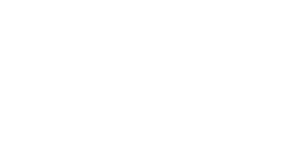

In [55]:
### color-coded categories
import matplotlib.colors as mcolors
import matplotlib
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))
ax.set_xlabel('$X$', fontsize=15)
ax.set_ylabel('$Y$', fontsize=15)
ax.set_zlabel('$Z$', fontsize=15)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig('../outputs/categories_3Deu.pdf')
# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Within-category attraction (correlation distance) calculated by cluster (results not reported)

In [56]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

,index,0,1,2,cr,bigcat,cat_name,label,typicality
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,2,0.241258
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0,0.122153
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0,0.030633
3,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0,0.027674
4,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0,0.086948
...,...,...,...,...,...,...,...,...,...
1319,1847,0.215718,0.272371,0.461966,0.803129,24,toy,3,0.051801
1320,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,2,0.119712
1321,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0,0.434160
1322,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,2,0.213302


In [57]:
### overall cartesian coordinates and typicality predict memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     76.99
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           9.99e-59
Time:                        15:59:06   Log-Likelihood:                -1739.8
No. Observations:                1324   AIC:                             3490.
Df Residuals:                    1319   BIC:                             3515.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0311      0.058     -0.537      0.5

In [58]:
### overall cartesian predict within-category attraction (correlation distance)
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array(clusters[idx[:-1]]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     77.33
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.38e-46
Time:                        15:59:06   Log-Likelihood:                -1771.5
No. Observations:                1324   AIC:                             3551.
Df Residuals:                    1320   BIC:                             3572.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8198      0.055    -14.944      0.0

In [59]:
### overall radius and typicality predict memorability
concept_radius_clus = np.sqrt((clusters.loc[:, 0:2]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     69.96
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.32e-29
Time:                        15:59:06   Log-Likelihood:                -1812.0
No. Observations:                1324   AIC:                             3630.
Df Residuals:                    1321   BIC:                             3646.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5527      0.086     -6.430      0.0

In [60]:
### overall radius predict within-category attraction (correlation distance)
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_clus, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     45.64
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.12e-11
Time:                        15:59:06   Log-Likelihood:                -1856.2
No. Observations:                1324   AIC:                             3716.
Df Residuals:                    1322   BIC:                             3727.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.5901      0.087      6.756      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 0: cartesian coordinates and typicality predict memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_0[idx]), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     29.26
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.12e-21
Time:                        15:59:06   Log-Likelihood:                -532.53
No. Observations:                 412   AIC:                             1075.
Df Residuals:                     407   BIC:                             1095.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2222      0.201     -1.106      0.2

In [62]:
### cluster 0: radius and typicality predict memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     44.64
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.92e-18
Time:                        15:59:06   Log-Likelihood:                -543.93
No. Observations:                 412   AIC:                             1094.
Df Residuals:                     409   BIC:                             1106.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.5185      0.176     -2.951      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
### cluster 1: cartesian coordinates and typicality predict memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_1[idx]), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     14.59
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.26e-10
Time:                        15:59:06   Log-Likelihood:                -305.48
No. Observations:                 234   AIC:                             621.0
Df Residuals:                     229   BIC:                             638.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3470      0.162     -2.143      0.0

In [64]:
### cluster 1: radius and typicality predict memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     20.63
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.73e-09
Time:                        15:59:06   Log-Likelihood:                -312.81
No. Observations:                 234   AIC:                             631.6
Df Residuals:                     231   BIC:                             642.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8483      0.217      3.910      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 2: cartesian coordinates and typicality predict memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(np.array(cluster_2[idx]), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.889
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0222
Time:                        15:59:06   Log-Likelihood:                -593.02
No. Observations:                 422   AIC:                             1196.
Df Residuals:                     417   BIC:                             1216.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1372      0.147      0.935      0.3

In [66]:
### cluster 2: radius and typicality predict memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.896
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0563
Time:                        15:59:06   Log-Likelihood:                -595.90
No. Observations:                 422   AIC:                             1198.
Df Residuals:                     419   BIC:                             1210.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3806      0.196     -1.939      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [67]:
# variances in mem explained by cartesian coordinates and typicality across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
r_squared

0.1413065662715164

In [68]:
# variances in mem explained by radius and typicality across clusters
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2))
r_squared

0.10770500964859642

In [69]:
### linreg: radius of original 49d embeddings and z-score memorability
zscore_mem = stats.zscore(cat_concept_mem['cr'])
mean_concept_constant = sm.add_constant(np.sqrt((original_embeddings**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.989
Date:                Thu, 24 Aug 2023   Prob (F-statistic):              0.159
Time:                        15:59:06   Log-Likelihood:                -2629.7
No. Observations:                1854   AIC:                             5263.
Df Residuals:                    1852   BIC:                             5274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1544      0.109     -1.410      0.1

### Human-rated typicality

In [70]:
# loading human-rated typicality
typ_mapped = typ_coord_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=('_computed', '_rated'))
typ_mapped

,index,0,1,2,cr,bigcat,cat_name,label,typicality_computed,cat,concept,typicality_rated
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,2,0.810913,1,0,4.874352
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0,0.247628,13,1,2.613022
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0,0.624589,18,2,5.605201
3,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0,0.522380,9,4,5.966682
4,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0,0.509185,12,5,4.451417
...,...,...,...,...,...,...,...,...,...,...,...,...
1614,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,2,0.786900,10,1848,7.064713
1615,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0,0.770485,10,1850,4.520777
1616,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,2,0.764335,1,1851,7.177455
1617,1853,-0.823824,0.768425,-0.851903,0.823237,10,food,0,0.705398,10,1853,6.354120


In [71]:
# Not all concepts have a category membership. Here we remove those who have no category
typ_mapped_drop_na = typ_mapped[typ_mapped['bigcat'] == typ_mapped['cat']]
typ_mapped_drop_na['radius'] = np.sqrt((typ_mapped_drop_na[[0,1,2]]**2).sum(1))
typ_mapped_drop_na

/var/folders/z0/2nnq77gs127ftm6v0pqpy_3c0000gn/T/ipykernel_22417/1103843986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  typ_mapped_drop_na['radius'] = np.sqrt((typ_mapped_drop_na[[0,1,2]]**2).sum(1))


,index,0,1,2,cr,bigcat,cat_name,label,typicality_computed,cat,concept,typicality_rated,radius
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,2,0.810913,1,0,4.874352,1.094030
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0,0.247628,13,1,2.613022,1.131080
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0,0.624589,18,2,5.605201,1.466918
3,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0,0.522380,9,4,5.966682,0.946217
4,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0,0.509185,12,5,4.451417,0.784966
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,1847,0.215718,0.272371,0.461966,0.803129,24,toy,3,0.246697,24,1847,7.111927,0.578043
1614,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,2,0.786900,10,1848,7.064713,1.010730
1615,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0,0.770485,10,1850,4.520777,1.086125
1616,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,2,0.764335,1,1851,7.177455,0.883218


In [72]:
# radius predict human-rated typicality
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_rated'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.894
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0153
Time:                        15:59:06   Log-Likelihood:                -1830.3
No. Observations:                1292   AIC:                             3665.
Df Residuals:                    1290   BIC:                             3675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.2190      0.090     -2.428      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [73]:
# human-rated typicality predict memorability
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[['typicality_rated']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1171
Date:                Thu, 24 Aug 2023   Prob (F-statistic):              0.732
Time:                        15:59:06   Log-Likelihood:                -1833.2
No. Observations:                1292   AIC:                             3670.
Df Residuals:                    1290   BIC:                             3681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
typicality_rated     0.0070      0.021  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [74]:
# radius and human-rated typicality predict memorability
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[['radius', 'typicality_rated']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.39
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.35e-05
Time:                        15:59:06   Log-Likelihood:                -1822.9
No. Observations:                1292   AIC:                             3652.
Df Residuals:                    1289   BIC:                             3667.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
radius              -0.4087      0.090  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Between-category repulsion

In [75]:
### compute between-category repulsion by avg/min Euclidean distance from all other categories
from sklearn import preprocessing 

def get_contrast_cat_typ(df, measure, cat_col, by):
    """
    measure = eu (euclidean)
    by = avg (typicality by avg distance) or min (typicality by min distance)
    """
    typ_contrast = {}
    for cat in df[cat_col].unique():
        category = df[df[cat_col] == cat]
        others = df[df[cat_col] != cat]
        for idx in range(len(category)):
            concept = category.iloc[idx]
            typ = 0.0
            if measure == 'eu':
                if by == 'avg':
                    typ = (np.sqrt(((others[[0,1,2]] - concept[[0,1,2]])**2).sum(1))).mean(0)
                else: 
                    typ = (np.sqrt(((others[[0,1,2]] - concept[[0,1,2]])**2).sum(1))).min(0)
            else:
                tmp = pd.concat([pd.DataFrame(concept).T, others])
                tmp[[0,1,2]] = tmp[[0,1,2]].astype(float)
                if by == 'avg':
                    typ = poincare_dist_vec(tmp[[0,1,2]].values)[0].mean(0)
                else:
                    typ = poincare_dist_vec(tmp[[0,1,2]].values)[0][1:].min()
            typ_contrast[concept.name] = typ
    df['typ_contrast'] = pd.Series(typ_contrast)
    # rescale typicality
    min_max_scaler = preprocessing.MinMaxScaler()
    df['typ_contrast'] = min_max_scaler.fit_transform(df[['typ_contrast']].values)
#     df['typ_contrast'] = 1 - df['typ_contrast']
    
    return df

# between-category repulsion: avg Euclidean distance
typ_tmp = typ_coord_cluster.copy(deep=True)
typ_tmp_avg = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'avg')
typ_tmp_avg['radius'] = np.sqrt((typ_tmp_avg[[0,1,2]]**2).sum(1))
typ_tmp_avg

,index,0,1,2,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,2,0.810913,0.130528,1.094030
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0,0.247628,0.101052,1.131080
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0,0.624589,0.207890,1.466918
3,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0,0.522380,0.035993,0.946217
4,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0,0.509185,0.077445,0.784966
...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.215718,0.272371,0.461966,0.803129,24,toy,3,0.246697,0.385922,0.578043
1320,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,2,0.786900,0.035181,1.010730
1321,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0,0.770485,0.128373,1.086125
1322,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,2,0.764335,0.084774,0.883218


In [76]:
# radius predict between-category repulsion
zscore_mem = stats.zscore(typ_tmp_avg['typ_contrast'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     68.44
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           3.15e-16
Time:                        15:59:10   Log-Likelihood:                -1845.3
No. Observations:                1324   AIC:                             3695.
Df Residuals:                    1322   BIC:                             3705.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.7167      0.087      8.273      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [77]:
# between-category repulsion predict memorability
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     87.19
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.04e-20
Time:                        15:59:10   Log-Likelihood:                -1836.4
No. Observations:                1324   AIC:                             3677.
Df Residuals:                    1322   BIC:                             3687.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
typ_contrast     1.7318      0.185      9.338   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [78]:
# radius and between-category repulsion predict memorability
zscore_mem = stats.zscore(typ_tmp_avg['cr'])
concept_constant = sm.add_constant(typ_tmp_avg[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     68.05
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           7.47e-29
Time:                        15:59:10   Log-Likelihood:                -1813.8
No. Observations:                1324   AIC:                             3634.
Df Residuals:                    1321   BIC:                             3649.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.5882      0.087     -6.778   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [79]:
# between-category repulsion: min Euclidean distance
typ_tmp_min = get_contrast_cat_typ(typ_tmp, 'eu', 'bigcat', 'min')
typ_tmp_min['radius'] = np.sqrt((typ_tmp_min[[0,1,2]]**2).sum(1))
typ_tmp_min

,index,0,1,2,cr,bigcat,cat_name,label,typicality,typ_contrast,radius
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,2,0.810913,0.115468,1.094030
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0,0.247628,0.073305,1.131080
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0,0.624589,0.127809,1.466918
3,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0,0.522380,0.010062,0.946217
4,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0,0.509185,0.159863,0.784966
...,...,...,...,...,...,...,...,...,...,...,...
1319,1847,0.215718,0.272371,0.461966,0.803129,24,toy,3,0.246697,0.152512,0.578043
1320,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,2,0.786900,0.097492,1.010730
1321,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0,0.770485,0.184278,1.086125
1322,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,2,0.764335,0.129925,0.883218


In [80]:
# radius predict between-category repulsion
zscore_mem = stats.zscore(typ_tmp_min['typ_contrast'])
concept_constant = sm.add_constant(typ_tmp_min[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     57.79
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.50e-14
Time:                        15:59:14   Log-Likelihood:                -1850.4
No. Observations:                1324   AIC:                             3705.
Df Residuals:                    1322   BIC:                             3715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         0.6611      0.087      7.602      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [81]:
# between-category repulsion predict memorability
zscore_mem = stats.zscore(typ_tmp_min['cr'])
concept_constant = sm.add_constant(typ_tmp_min[['typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.299
Date:                Thu, 24 Aug 2023   Prob (F-statistic):             0.0122
Time:                        15:59:14   Log-Likelihood:                -1875.5
No. Observations:                1324   AIC:                             3755.
Df Residuals:                    1322   BIC:                             3765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
typ_contrast     0.5300      0.211      2.510   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [82]:
# radius and between-category repulsion predict memorability
zscore_mem = stats.zscore(typ_tmp_min['cr'])
concept_constant = sm.add_constant(typ_tmp_min[['radius', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     15.51
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.20e-07
Time:                        15:59:14   Log-Likelihood:                -1863.3
No. Observations:                1324   AIC:                             3733.
Df Residuals:                    1321   BIC:                             3748.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.4452      0.090     -4.960   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
# For each cluster, print out the linear regression result of cartesian coordinates predicting between-category repulsion (avg Euclidean) 
fittedvalues_list = []
zscore_mem_list = []

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['typ_contrast'])
    concept_constant = sm.add_constant(gp[[0,1,2]], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:           typ_contrast   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     22.09
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.83e-13
Time:                        15:59:14   Log-Likelihood:                -553.60
No. Observations:                 412   AIC:                             1115.
Df Residuals:                     408   BIC:                             1131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.6198      0.210     -7.707      0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.20426006982057665

In [84]:
# For each cluster, print out the linear regression result of between-category repulsion (avg Euclidean) predicting mem
fittedvalues_list = []
zscore_mem_list = []

for c in sorted(typ_tmp_avg['label'].unique()):
    gp = typ_tmp_avg[typ_tmp_avg['label'] == c]
    zscore_mem = stats.zscore(gp['cr'])
    concept_constant = sm.add_constant(gp[[0,1,2, 'typ_contrast']], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    print(c)
    print(res.summary())
        
    zscore_mem_list.append(zscore_mem)
    fittedvalues_list.append(res.fittedvalues)
    
r_squared = 1 - (sum((zscore_mem_list[0] - fittedvalues_list[0])**2) + sum((zscore_mem_list[1] - fittedvalues_list[1])**2) + sum((zscore_mem_list[2] - fittedvalues_list[2])**2) + sum((zscore_mem_list[3] - fittedvalues_list[3])**2)) / (sum((zscore_mem_list[0] - zscore_mem_list[0].mean())**2) + sum((zscore_mem_list[1] - zscore_mem_list[1].mean())**2) + sum((zscore_mem_list[2] - zscore_mem_list[2].mean())**2) + sum((zscore_mem_list[3] - zscore_mem_list[3].mean())**2))
r_squared

0
                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     5.226
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           0.000410
Time:                        15:59:14   Log-Likelihood:                -574.29
No. Observations:                 412   AIC:                             1159.
Df Residuals:                     407   BIC:                             1179.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0               -0.3739      0.237     -1.579 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.07563520673659807

### Within-category attraction (Euclidean distance)

In [85]:
def in_cat_typ(group):
    """
    Compute within-category attraction using Euclidean distance 
        between each concept and all other concepts in the same category
    """
    coef_matrix = np.corrcoef(group[[0,1,2]])
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality_dist'] = typicality
    return group

df_typ = mean_concept_in_feat_cat_na.groupby('bigcat').apply(in_cat_typ)
df_typ = df_typ.groupby('bigcat').apply(calculate_typicality)
df_typ = get_contrast_cat_typ(df_typ, 'eu', 'bigcat', 'avg')
df_typ['radius'] = np.sqrt((df_typ[[0,1,2]]**2).sum(1))
df_typ

,index,0,1,2,cr,bigcat,cat_name,typicality_dist,typicality,typ_contrast,radius
0,0,0.051500,0.483172,-0.980202,0.779739,1,animal,0.967686,0.810913,0.130528,1.094030
1,1,-0.607218,0.881249,-0.366100,0.798485,13,home decor,0.361904,0.247628,0.101052,1.131080
2,2,-0.697082,1.164975,-0.555658,0.752845,18,musical instrument,0.879125,0.624589,0.207890,1.466918
4,4,-0.687007,0.409919,-0.505287,0.794466,9,electronic device,0.769000,0.522380,0.035993,0.946217
5,5,-0.678579,0.211290,-0.333254,0.806000,12,furniture,0.666580,0.509185,0.077445,0.784966
...,...,...,...,...,...,...,...,...,...,...,...
1847,1847,0.215718,0.272371,0.461966,0.803129,24,toy,-0.261818,0.246697,0.385922,0.578043
1848,1848,-0.476999,0.372665,-0.809425,0.765881,10,food,0.857165,0.786900,0.035181,1.010730
1850,1850,-0.575528,0.803189,-0.450914,0.843158,10,food,0.941946,0.770485,0.128373,1.086125
1851,1851,0.029682,0.494576,-0.731155,0.800163,1,animal,0.962411,0.764335,0.084774,0.883218


In [86]:
# radius predict within-category attraction (Euclidean distance)
zscore_mem = stats.zscore(df_typ['typicality_dist'])
concept_constant = sm.add_constant(df_typ[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        typicality_dist   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     213.6
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.91e-45
Time:                        15:59:18   Log-Likelihood:                -1779.5
No. Observations:                1324   AIC:                             3563.
Df Residuals:                    1322   BIC:                             3573.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius         1.2048      0.082     14.615      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [87]:
# within-category attraction (Euclidean distance) predict memorability
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['typicality_dist']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.896
Date:                Thu, 24 Aug 2023   Prob (F-statistic):            0.00503
Time:                        15:59:18   Log-Likelihood:                -1874.7
No. Observations:                1324   AIC:                             3753.
Df Residuals:                    1322   BIC:                             3764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
typicality_dist    -0.2265      0.081     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [88]:
# radius and within-category attraction (Euclidean distance) predict memorability
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['radius', 'typicality_dist']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     10.18
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.09e-05
Time:                        15:59:18   Log-Likelihood:                -1868.5
No. Observations:                1324   AIC:                             3743.
Df Residuals:                    1321   BIC:                             3759.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
radius             -0.3347      0.095     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [89]:
# radius, within-category attraction (Euclidean distance), and between-category repulsion (avg Euclidean) predict mem
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['radius', 'typicality_dist', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     50.64
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           5.56e-31
Time:                        15:59:18   Log-Likelihood:                -1806.6
No. Observations:                1324   AIC:                             3621.
Df Residuals:                    1320   BIC:                             3642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
radius             -0.7675      0.098     

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [90]:
# radius, within-category attraction (correlation distance), and between-category repulsion (avg Euclidean) predict mem
zscore_mem = stats.zscore(df_typ['cr'])
concept_constant = sm.add_constant(df_typ[['radius', 'typicality', 'typ_contrast']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     86.45
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.53e-51
Time:                        15:59:18   Log-Likelihood:                -1759.9
No. Observations:                1324   AIC:                             3528.
Df Residuals:                    1320   BIC:                             3549.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
radius          -0.7717      0.085     -9.063   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


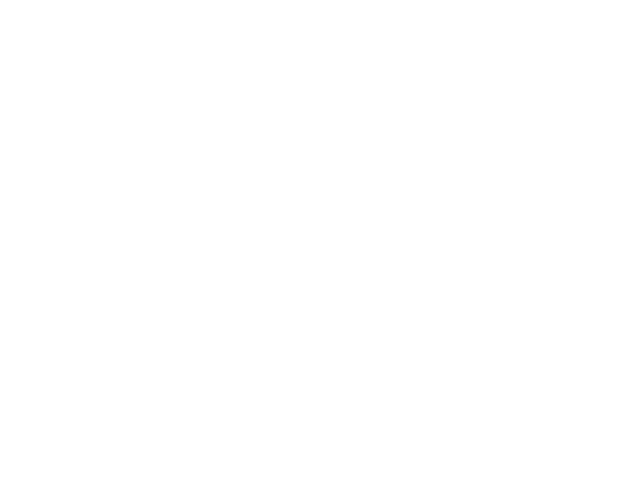

In [91]:
# correlation matrix of within-category attraction (correlation, Euclidean) and between-category repulsion
%matplotlib notebook

corr_matrix = df_typ[['typicality', 'typ_contrast']]
corr_matrix = corr_matrix.rename(columns = {'typicality': 'within-category \n attraction', 'typ_contrast':'between-category \n repulsion'})
corr_matrix = corr_matrix.corr()
colormap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=colormap)
plt.show()